ZipCode Model Creation

## Import libraries and datasets

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from math import sqrt
from math import log
from math import exp
from scipy.stats import boxcox 
from pandas import DataFrame
from pandas import Grouper
from pandas import Series
from pandas import concat
from pandas.plotting import lag_plot
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from matplotlib import pyplot
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARMA, ARIMA
from statsmodels.tsa.statespace import sarimax
from statsmodels.tsa.arima_model import ARIMAResults
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.gofplots import qqplot
import warnings

In [2]:
df = pd.read_csv('data/zillow_data.csv')
df_income = pd.read_csv('data/zip_codes_2019_median_inc.csv')

In [3]:
df.columns = df.columns.str.strip().str.lower()
df_income.columns = df_income.columns.str.strip().str.lower()

## Standardizing data/fixing col names

In [4]:
df.rename(columns={'regionname': 'zipcode', 'countyname':'county'},inplace=True)
df_income.rename(columns={
    'zip code':'zipcode', 'population (2019)': 'population',
    'median family income (2019)': 'median_family_income'},
                 inplace=True)

In [5]:
df = df[df['state']=='TX']
df_income['state'] = df_income['preferred name'].str.slice(-2)
df_income = df_income[df_income['state']=='TX']
df_income = (df_income[df_income['type'] != 'PO box'])

In [6]:
df_income.head()

,zipcode,type,state fips,preferred name,alternate names,population,housing units (2019),median_family_income,mfi percentile (2019),latitude,longitude,land area,water area,state
31142,73301,unique,48,"Austin, TX",Irs Service Center,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TX
31143,73344,unique,48,"Austin, TX",Irs Service Center,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TX
31744,75001,standard,48,"Addison, TX",NaN,"14,992","9,298","$79,551",68.0,32.959999,-96.838997,3.834,0.003,TX
31745,75002,standard,48,"Allen, TX","Lucas, Parker","71,253","23,314","$105,656",88.0,33.090000,-96.609001,37.179,2.056,TX
31746,75006,standard,48,"Carrollton, TX",NaN,"51,642","19,178","$72,325",57.0,32.962002,-96.899002,16.875,0.254,TX


### Adding some statistical columns

In [7]:
#Calculate historical return on investment
df['ROI']= (df['2018-04']/df['1996-04'])-1
df['ROI']


#Calculate standard deviation of monthly values
df['std']=df.loc[:,'1996-04':'2018-04'].std(skipna=True, axis=1)

#Calculate historical mean value
df['mean']=df.loc[:,'1996-04':'2018-04'].mean(skipna=True, axis=1)

# Calculate historical median value
df['median']=df.loc[:,'1996-04':'2018-04'].median(skipna=True,axis=1)

#Calculate coefficient of variance
df['CV']=df['std']/df['mean']

#Show calculated values
df[['zipcode','std','mean','ROI','CV']].head()

#Descriptive statistics of coefficients of variance.
print(df.CV.describe())

#Define upper limit of CV according to risk profile.
upper_cv = df.CV.quantile(.6)
print(f'\nCV upper limit: {upper_cv}')

#Get the 5 zipcodes with highest ROIs within the firms risk profile.
zc_best5 = df[df['CV']<upper_cv].sort_values('ROI',axis=0,ascending=False)[:5]
print('\n Best 5 Zipcodes:')
zc_best5[['zipcode','ROI','CV']]

warnings.filterwarnings

count    989.000000
mean       0.167433
std        0.041415
min        0.045182
25%        0.142279
50%        0.165783
75%        0.189448
max        0.361446
Name: CV, dtype: float64

CV upper limit: 0.17479440936725246

 Best 5 Zipcodes:


<function warnings.filterwarnings(action, message='', category=<class 'Warning'>, module='', lineno=0, append=False)>

### More cleaning, renaming, filtering

In [8]:
# RegionID is something from Zillow, don't need it and we don't need state any more.
df.drop(['regionid', 'sizerank', 'metro'], axis=1,inplace=True)

In [9]:
# we only want zipcode, pop, mfi, lat and long from 2019 income data
df_income = df_income[df_income.columns[np.r_[0,5,7,9:11]]]
df_income

,zipcode,population,median_family_income,latitude,longitude
31142,73301,NaN,NaN,NaN,NaN
31143,73344,NaN,NaN,NaN,NaN
31744,75001,"14,992","$79,551",32.959999,-96.838997
31745,75002,"71,253","$105,656",33.090000,-96.609001
31746,75006,"51,642","$72,325",32.962002,-96.899002
...,...,...,...,...,...
34257,79961,NaN,NaN,NaN,NaN
34258,79968,NaN,NaN,NaN,NaN
34259,79976,NaN,NaN,NaN,NaN
34260,79978,NaN,NaN,NaN,NaN


In [10]:
# fixing mfi and pop columns
df_income['median_family_income'] = df_income['median_family_income'].str.strip('$\n\t')
df_income['median_family_income'] = df_income['median_family_income'].str.replace(',','')
df_income = df_income[df_income['median_family_income'].notna()]
df_income['median_family_income'] = df_income['median_family_income'].astype(int)
df_income['population'] = df_income['population'].str.replace(',','')
df_income['population'] = df_income['population'].astype(int)

<ipython-input-10-07f5f36c8a35>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_income['median_family_income'] = df_income['median_family_income'].astype(int)
<ipython-input-10-07f5f36c8a35>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_income['population'] = df_income['population'].str.replace(',','')
<ipython-input-10-07f5f36c8a35>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

In [11]:
df_income.head()

,zipcode,population,median_family_income,latitude,longitude
31744,75001,14992,79551,32.959999,-96.838997
31745,75002,71253,105656,33.090000,-96.609001
31746,75006,51642,72325,32.962002,-96.899002
31747,75007,55500,96094,33.005001,-96.897003
31748,75009,14089,117857,33.339001,-96.752998


In [12]:
def melt_data(df):
    melted = pd.melt(df, id_vars=['zipcode', 'city', 'state', 'county','ROI','std','mean','median','CV'], var_name='date')
    melted['date'] = pd.to_datetime(melted['date'], infer_datetime_format=True)
    melted['year'] = [d.year for d in melted.date]
    melted = melted.dropna(subset=['value'])
    return melted

In [13]:
df = melt_data(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 255096 entries, 0 to 262084
Data columns (total 12 columns):
 #   Column   Non-Null Count   Dtype         
---  ------   --------------   -----         
 0   zipcode  255096 non-null  int64         
 1   city     255096 non-null  object        
 2   state    255096 non-null  object        
 3   county   255096 non-null  object        
 4   ROI      250160 non-null  float64       
 5   std      255096 non-null  float64       
 6   mean     255096 non-null  float64       
 7   median   255096 non-null  float64       
 8   CV       255096 non-null  float64       
 9   date     255096 non-null  datetime64[ns]
 10  value    255096 non-null  float64       
 11  year     255096 non-null  int64         
dtypes: datetime64[ns](1), float64(6), int64(2), object(3)
memory usage: 25.3+ MB


In [14]:
df.set_index(df['date'], inplace = True)
df.drop('date',axis=1, inplace=True)
df

,zipcode,city,state,county,ROI,std,mean,median,CV,value,year
date,,,,,,,,,,,
1996-04-01,75070,McKinney,TX,Collin,0.365295,33537.101427,219655.849057,205900.0,0.152680,235700.0,1996
1996-04-01,77494,Katy,TX,Harris,0.567966,37730.794353,262110.566038,249700.0,0.143950,210400.0,1996
1996-04-01,79936,El Paso,TX,El Paso,0.571798,18167.079218,101875.471698,112400.0,0.178326,77300.0,1996
1996-04-01,77084,Houston,TX,Harris,0.729474,17242.109812,121185.283019,121400.0,0.142279,95000.0,1996
1996-04-01,77449,Katy,TX,Harris,0.846960,18603.288493,126530.188679,124600.0,0.147026,95400.0,1996
...,...,...,...,...,...,...,...,...,...,...,...
2018-04-01,76941,Mertzon,TX,Irion,NaN,13734.029878,99318.367347,95600.0,0.138283,121600.0,2018
2018-04-01,79313,Anton,TX,Hockley,NaN,5286.674724,54424.675325,53500.0,0.097137,63300.0,2018
2018-04-01,79355,Plains,TX,Yoakum,NaN,12929.465872,78967.346939,77050.0,0.163732,93500.0,2018


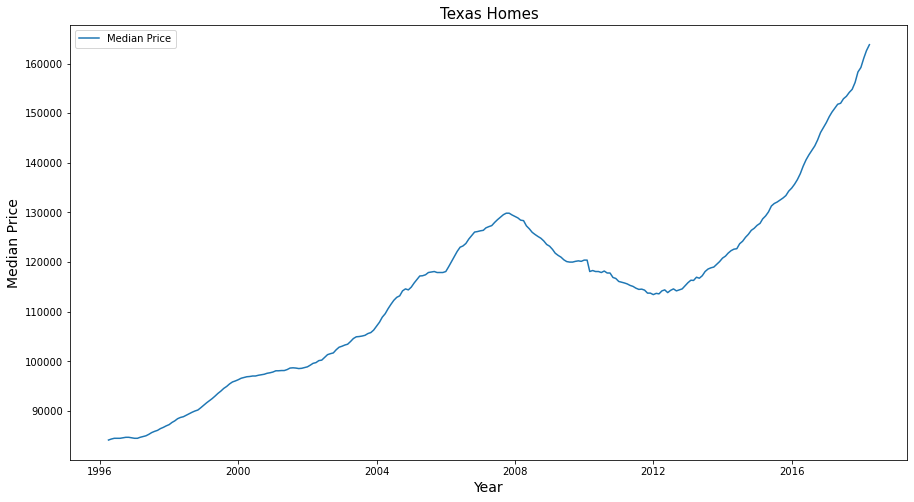

In [96]:
fig, ax = plt.subplots()
ax.set_title('Texas Homes', fontsize=15)
ax.set_xlabel('Year', fontsize=14)
ax.set_ylabel('Median Price', fontsize=14)
sns.lineplot(data=df.groupby('date').aggregate({'value':'median'}))
plt.legend(['Median Price'])
fig.set_size_inches(15,8);

## Merging dfs on zip

In [16]:
df_merged = df.reset_index().merge(df_income, how='left').set_index('date')
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 255096 entries, 1996-04-01 to 2018-04-01
Data columns (total 15 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   zipcode               255096 non-null  int64  
 1   city                  255096 non-null  object 
 2   state                 255096 non-null  object 
 3   county                255096 non-null  object 
 4   ROI                   250160 non-null  float64
 5   std                   255096 non-null  float64
 6   mean                  255096 non-null  float64
 7   median                255096 non-null  float64
 8   CV                    255096 non-null  float64
 9   value                 255096 non-null  float64
 10  year                  255096 non-null  int64  
 11  population            252181 non-null  float64
 12  median_family_income  252181 non-null  float64
 13  latitude              252181 non-null  float64
 14  longitude             252181 non-nul

In [17]:
df_merged_for_later = df_merged

In [18]:
df_merged.describe().T

,count,mean,std,min,25%,50%,75%,max
zipcode,255096.0,77163.777546,1361.342308,75001.000000,76017.000000,77098.000000,78251.000000,7.993800e+04
ROI,250160.0,0.940549,0.418125,-0.375469,0.721048,0.903395,1.101759,6.550360e+00
std,255096.0,23762.532113,16134.709292,2684.773009,13998.832825,19663.932774,29134.083926,1.437548e+05
mean,255096.0,140540.600793,94822.092356,32718.292683,81482.641509,115224.150943,165333.207547,8.802596e+05
median,255096.0,140492.897184,92524.819570,32150.000000,82400.000000,116300.000000,165000.000000,8.901000e+05
CV,255096.0,0.168955,0.040480,0.045182,0.144163,0.166917,0.189818,3.614458e-01
value,255096.0,140540.600793,99061.016727,24100.000000,79900.000000,113700.000000,165100.000000,1.268600e+06
year,255096.0,2006.908003,6.393508,1996.000000,2001.000000,2007.000000,2012.000000,2.018000e+03
population,252181.0,25939.370892,20385.536014,1056.000000,9761.000000,21879.000000,37281.000000,1.282940e+05
median_family_income,252181.0,77689.448301,32642.262099,21169.000000,56108.000000,69722.000000,90867.000000,2.500010e+05


### Filtering merged df

In [19]:
df_merged_upper_pop = df_merged['population'].quantile(.75)
df_filtered = df_merged[(df_merged['population'] > df_merged_upper_pop)]

In [20]:
# Select the first quantile
q1 = df_filtered['value'].quantile(.25)

# Select the third quantile
q3 = df_filtered['value'].quantile(.75)


# Create a filtered in between q1 & q3
filtered = df_filtered[(df_filtered['value']>=q1) 
             & (df_filtered['value']<=q3)]
df_filtered = pd.DataFrame(filtered)
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 31421 entries, 1996-04-01 to 2018-04-01
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   zipcode               31421 non-null  int64  
 1   city                  31421 non-null  object 
 2   state                 31421 non-null  object 
 3   county                31421 non-null  object 
 4   ROI                   31421 non-null  float64
 5   std                   31421 non-null  float64
 6   mean                  31421 non-null  float64
 7   median                31421 non-null  float64
 8   CV                    31421 non-null  float64
 9   value                 31421 non-null  float64
 10  year                  31421 non-null  int64  
 11  population            31421 non-null  float64
 12  median_family_income  31421 non-null  float64
 13  latitude              31421 non-null  float64
 14  longitude             31421 non-null  float64
dtypes:

## Creating an Affordability Score

In [21]:
# group by date and aggregate on median value
df_filtered['median_house_price'] = df_filtered.groupby('date').aggregate({'value':'median'})
df_filtered['affordability'] = df_filtered['value'] - df_filtered['median_family_income']/.12

In [22]:
# create function to normalize data
def normalize_data(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))
df_filtered['affordability_score']  = normalize_data(df_filtered['affordability'])
df_filtered

,zipcode,city,state,county,ROI,std,mean,median,CV,value,year,population,median_family_income,latitude,longitude,median_house_price,affordability,affordability_score
date,,,,,,,,,,,,,,,,,,
1996-04-01,78660,Pflugerville,TX,Travis,0.748020,24894.592870,168193.584906,165100.0,0.148012,138900.0,1996,91300.0,99733.0,30.440001,-97.595001,124500.0,-692208.333333,0.409033
1996-04-01,77573,League City,TX,Galveston,0.848656,29647.359699,183261.509434,183500.0,0.161776,141400.0,1996,88131.0,121943.0,29.504000,-95.086998,124500.0,-874791.666667,0.221835
1996-04-01,77584,Pearland,TX,Brazoria,0.851986,27064.756641,188628.301887,188400.0,0.143482,138500.0,1996,90372.0,126143.0,29.545000,-95.350998,124500.0,-912691.666667,0.182977
1996-04-01,79912,El Paso,TX,El Paso,0.571429,26245.575483,154012.075472,171800.0,0.170412,119700.0,1996,78267.0,77146.0,31.849001,-106.533997,124500.0,-523183.333333,0.582329
1996-04-01,78130,New Braunfels,TX,Comal,0.784504,23349.861603,153368.301887,154900.0,0.152247,123900.0,1996,77400.0,76824.0,29.694000,-98.072998,124500.0,-516300.000000,0.589387
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-04-01,78552,Harlingen,TX,Cameron,0.468835,9181.535729,85940.377358,85700.0,0.106836,108400.0,2018,37948.0,52891.0,26.194000,-97.750999,144750.0,-332358.333333,0.777977
2018-04-01,77014,Houston,TX,Harris,0.619588,15782.797130,122692.452830,123300.0,0.128637,157100.0,2018,37488.0,55613.0,29.981001,-95.463997,144750.0,-306341.666667,0.804651
2018-04-01,77506,Pasadena,TX,Harris,1.255187,12538.003841,69982.264151,70900.0,0.179160,108700.0,2018,38765.0,46462.0,29.714001,-95.199997,144750.0,-278483.333333,0.833214


In [23]:
df_merged_for_later

,zipcode,city,state,county,ROI,std,mean,median,CV,value,year,population,median_family_income,latitude,longitude
date,,,,,,,,,,,,,,,
1996-04-01,75070,McKinney,TX,Collin,0.365295,33537.101427,219655.849057,205900.0,0.152680,235700.0,1996,104415.0,115530.0,33.172001,-96.695999
1996-04-01,77494,Katy,TX,Harris,0.567966,37730.794353,262110.566038,249700.0,0.143950,210400.0,1996,118291.0,148843.0,29.740999,-95.830002
1996-04-01,79936,El Paso,TX,El Paso,0.571798,18167.079218,101875.471698,112400.0,0.178326,77300.0,1996,111620.0,61016.0,31.777000,-106.296997
1996-04-01,77084,Houston,TX,Harris,0.729474,17242.109812,121185.283019,121400.0,0.142279,95000.0,1996,107673.0,70460.0,29.827000,-95.660004
1996-04-01,77449,Katy,TX,Harris,0.846960,18603.288493,126530.188679,124600.0,0.147026,95400.0,1996,128294.0,82716.0,29.837999,-95.734001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-04-01,76941,Mertzon,TX,Irion,NaN,13734.029878,99318.367347,95600.0,0.138283,121600.0,2018,1455.0,64464.0,31.271999,-100.889000
2018-04-01,79313,Anton,TX,Hockley,NaN,5286.674724,54424.675325,53500.0,0.097137,63300.0,2018,1528.0,49250.0,33.805000,-102.162003
2018-04-01,79355,Plains,TX,Yoakum,NaN,12929.465872,78967.346939,77050.0,0.163732,93500.0,2018,1877.0,64563.0,33.181999,-102.876999


In [24]:
# filtering to the 20th percentile
top_20 = df_filtered['affordability_score'].quantile(.5)
top_20

0.5827053536337383

In [25]:
df_filtered

,zipcode,city,state,county,ROI,std,mean,median,CV,value,year,population,median_family_income,latitude,longitude,median_house_price,affordability,affordability_score
date,,,,,,,,,,,,,,,,,,
1996-04-01,78660,Pflugerville,TX,Travis,0.748020,24894.592870,168193.584906,165100.0,0.148012,138900.0,1996,91300.0,99733.0,30.440001,-97.595001,124500.0,-692208.333333,0.409033
1996-04-01,77573,League City,TX,Galveston,0.848656,29647.359699,183261.509434,183500.0,0.161776,141400.0,1996,88131.0,121943.0,29.504000,-95.086998,124500.0,-874791.666667,0.221835
1996-04-01,77584,Pearland,TX,Brazoria,0.851986,27064.756641,188628.301887,188400.0,0.143482,138500.0,1996,90372.0,126143.0,29.545000,-95.350998,124500.0,-912691.666667,0.182977
1996-04-01,79912,El Paso,TX,El Paso,0.571429,26245.575483,154012.075472,171800.0,0.170412,119700.0,1996,78267.0,77146.0,31.849001,-106.533997,124500.0,-523183.333333,0.582329
1996-04-01,78130,New Braunfels,TX,Comal,0.784504,23349.861603,153368.301887,154900.0,0.152247,123900.0,1996,77400.0,76824.0,29.694000,-98.072998,124500.0,-516300.000000,0.589387
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-04-01,78552,Harlingen,TX,Cameron,0.468835,9181.535729,85940.377358,85700.0,0.106836,108400.0,2018,37948.0,52891.0,26.194000,-97.750999,144750.0,-332358.333333,0.777977
2018-04-01,77014,Houston,TX,Harris,0.619588,15782.797130,122692.452830,123300.0,0.128637,157100.0,2018,37488.0,55613.0,29.981001,-95.463997,144750.0,-306341.666667,0.804651
2018-04-01,77506,Pasadena,TX,Harris,1.255187,12538.003841,69982.264151,70900.0,0.179160,108700.0,2018,38765.0,46462.0,29.714001,-95.199997,144750.0,-278483.333333,0.833214


### Stratifying on Affordability Score

In [26]:
df_filtered_20 = df_filtered[(df_filtered['affordability_score'] < top_20)] 

In [27]:
df_filtered_20.reset_index().isna().sum()

date                    0
zipcode                 0
city                    0
state                   0
county                  0
ROI                     0
std                     0
mean                    0
median                  0
CV                      0
value                   0
year                    0
population              0
median_family_income    0
latitude                0
longitude               0
median_house_price      0
affordability           0
affordability_score     0
dtype: int64

In [28]:
df_filtered_2017 = df_filtered_20['2017-01-01':].dropna()

In [29]:
df_filtered_2017 = df_filtered_2017.reset_index()
df_filtered_top_roi = df_filtered_2017.loc[df_filtered_2017.groupby("zipcode")["ROI"].idxmax()].sort_values('ROI',axis=0,ascending=False)[:5]
df_filtered_top_roi.set_index('date',inplace=True)
df_filtered_top_roi

,zipcode,city,state,county,ROI,std,mean,median,CV,value,year,population,median_family_income,latitude,longitude,median_house_price,affordability,affordability_score
date,,,,,,,,,,,,,,,,,,
2017-01-01,79423,Lubbock,TX,Lubbock,1.082037,21451.329003,105156.226415,112700.0,0.203995,139000.0,2017,40303.0,82989.0,33.439999,-101.855003,145050.0,-552575.000000,0.552195
2017-01-01,77571,La Porte,TX,Harris,1.040936,20507.800452,116197.358491,118400.0,0.176491,153100.0,2017,37427.0,85150.0,29.688000,-95.056999,145050.0,-556483.333333,0.548188
2017-01-01,76108,Fort Worth,TX,Tarrant,1.013480,17152.126989,106005.660377,102700.0,0.161804,143500.0,2017,43169.0,80040.0,32.787998,-97.524002,145050.0,-523500.000000,0.582005
2017-01-01,75052,Grand Prairie,TX,Dallas,0.995040,19370.586349,134230.188679,130700.0,0.144309,176200.0,2017,95495.0,85220.0,32.665001,-97.025002,145050.0,-533966.666667,0.571274
2017-01-01,75104,Cedar Hill,TX,Dallas,0.954222,18302.905606,129367.924528,126600.0,0.141479,166100.0,2017,49171.0,83143.0,32.580002,-96.964996,145050.0,-526758.333333,0.578664


## Zipcode List

In [30]:
zipcodes = list(df_filtered_20['zipcode'].values)

In [31]:
df_filtered_top_roi = df_filtered_top_roi[df_filtered_top_roi['zipcode'].isin(zipcodes)]

In [32]:
df_merged = df_merged[df_merged['zipcode'].isin(zipcodes)]

In [33]:
df_merged['zipcode'].value_counts()

79705    265
77546    265
77377    265
77521    265
79762    265
        ... 
77070    265
75023    265
75071    265
77406    265
78230    265
Name: zipcode, Length: 96, dtype: int64

## Pivot Zips

In [34]:
df_prices = pd.DataFrame(df_merged[['zipcode','value']], index = df_merged.index)
df_prices.reset_index(inplace=True)

df_prices = df_prices.pivot('date', 'zipcode', 'value')
df_prices

zipcode,75002,75007,75023,75044,75052,75056,75068,75071,75074,75075,...,78665,78681,78748,79109,79423,79424,79705,79707,79762,79912
date,,,,,,,,,,,,,,,,,,,,,
1996-04-01,154600.0,127700.0,146400.0,101000.0,100800.0,145600.0,144300.0,186600.0,122400.0,151600.0,...,160700.0,171000.0,199500.0,82000.0,70700.0,111500.0,131000.0,146200.0,82100.0,119700.0
1996-05-01,153700.0,127700.0,145800.0,101000.0,100900.0,144600.0,143500.0,184700.0,122200.0,151200.0,...,160300.0,170900.0,198800.0,81900.0,70900.0,111700.0,130800.0,146100.0,82000.0,119700.0
1996-06-01,153000.0,127700.0,145300.0,101100.0,101000.0,143500.0,142800.0,183200.0,122100.0,150900.0,...,160100.0,171000.0,197900.0,81900.0,71200.0,111900.0,130700.0,145900.0,82000.0,119800.0
1996-07-01,152400.0,127700.0,144900.0,101100.0,101000.0,142500.0,142200.0,182100.0,122000.0,150700.0,...,160200.0,171500.0,196700.0,81900.0,71500.0,112100.0,130500.0,145800.0,81900.0,119900.0
1996-08-01,152000.0,127800.0,144600.0,101100.0,101200.0,141600.0,141700.0,181400.0,122000.0,150600.0,...,160500.0,172300.0,195100.0,81900.0,71800.0,112200.0,130400.0,145700.0,81800.0,120000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-01,285300.0,260600.0,269300.0,211400.0,194300.0,270200.0,258200.0,304600.0,228000.0,296800.0,...,258900.0,291500.0,276700.0,156000.0,147900.0,200800.0,254200.0,282000.0,151200.0,184700.0
2018-01-01,287200.0,260900.0,271700.0,213400.0,195200.0,271200.0,258400.0,306000.0,230800.0,299000.0,...,258900.0,292600.0,277800.0,156200.0,148200.0,200700.0,256300.0,284000.0,151700.0,184800.0
2018-02-01,288500.0,262600.0,274900.0,216400.0,196700.0,272500.0,259300.0,308600.0,232600.0,302200.0,...,259500.0,293800.0,279000.0,156600.0,148200.0,200400.0,258200.0,286700.0,153200.0,185900.0


In [35]:
df_prices.columns

Int64Index([75002, 75007, 75023, 75044, 75052, 75056, 75068, 75071, 75074,
            75075, 75080, 75081, 75098, 75104, 75115, 75126, 75154, 75165,
            75703, 76017, 76028, 76063, 76108, 76131, 76137, 76179, 76210,
            76244, 76502, 76513, 77044, 77064, 77070, 77077, 77089, 77095,
            77339, 77346, 77373, 77375, 77377, 77379, 77386, 77388, 77396,
            77406, 77407, 77429, 77433, 77449, 77450, 77459, 77469, 77479,
            77498, 77511, 77521, 77539, 77546, 77571, 77573, 77581, 77583,
            77584, 77845, 78045, 78108, 78109, 78154, 78230, 78232, 78247,
            78249, 78250, 78251, 78253, 78254, 78413, 78414, 78504, 78610,
            78613, 78640, 78641, 78660, 78664, 78665, 78681, 78748, 79109,
            79423, 79424, 79705, 79707, 79762, 79912],
           dtype='int64', name='zipcode')

In [36]:
df_merged = df.reset_index().merge(df_income, how='left').set_index('date')

In [37]:
df

,zipcode,city,state,county,ROI,std,mean,median,CV,value,year
date,,,,,,,,,,,
1996-04-01,75070,McKinney,TX,Collin,0.365295,33537.101427,219655.849057,205900.0,0.152680,235700.0,1996
1996-04-01,77494,Katy,TX,Harris,0.567966,37730.794353,262110.566038,249700.0,0.143950,210400.0,1996
1996-04-01,79936,El Paso,TX,El Paso,0.571798,18167.079218,101875.471698,112400.0,0.178326,77300.0,1996
1996-04-01,77084,Houston,TX,Harris,0.729474,17242.109812,121185.283019,121400.0,0.142279,95000.0,1996
1996-04-01,77449,Katy,TX,Harris,0.846960,18603.288493,126530.188679,124600.0,0.147026,95400.0,1996
...,...,...,...,...,...,...,...,...,...,...,...
2018-04-01,76941,Mertzon,TX,Irion,NaN,13734.029878,99318.367347,95600.0,0.138283,121600.0,2018
2018-04-01,79313,Anton,TX,Hockley,NaN,5286.674724,54424.675325,53500.0,0.097137,63300.0,2018
2018-04-01,79355,Plains,TX,Yoakum,NaN,12929.465872,78967.346939,77050.0,0.163732,93500.0,2018


In [38]:
df_merged_for_later

,zipcode,city,state,county,ROI,std,mean,median,CV,value,year,population,median_family_income,latitude,longitude
date,,,,,,,,,,,,,,,
1996-04-01,75070,McKinney,TX,Collin,0.365295,33537.101427,219655.849057,205900.0,0.152680,235700.0,1996,104415.0,115530.0,33.172001,-96.695999
1996-04-01,77494,Katy,TX,Harris,0.567966,37730.794353,262110.566038,249700.0,0.143950,210400.0,1996,118291.0,148843.0,29.740999,-95.830002
1996-04-01,79936,El Paso,TX,El Paso,0.571798,18167.079218,101875.471698,112400.0,0.178326,77300.0,1996,111620.0,61016.0,31.777000,-106.296997
1996-04-01,77084,Houston,TX,Harris,0.729474,17242.109812,121185.283019,121400.0,0.142279,95000.0,1996,107673.0,70460.0,29.827000,-95.660004
1996-04-01,77449,Katy,TX,Harris,0.846960,18603.288493,126530.188679,124600.0,0.147026,95400.0,1996,128294.0,82716.0,29.837999,-95.734001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-04-01,76941,Mertzon,TX,Irion,NaN,13734.029878,99318.367347,95600.0,0.138283,121600.0,2018,1455.0,64464.0,31.271999,-100.889000
2018-04-01,79313,Anton,TX,Hockley,NaN,5286.674724,54424.675325,53500.0,0.097137,63300.0,2018,1528.0,49250.0,33.805000,-102.162003
2018-04-01,79355,Plains,TX,Yoakum,NaN,12929.465872,78967.346939,77050.0,0.163732,93500.0,2018,1877.0,64563.0,33.181999,-102.876999


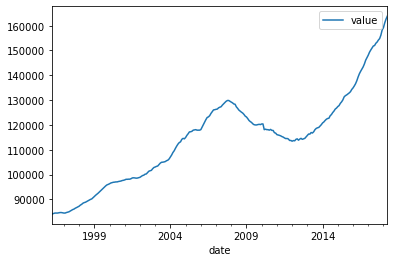

In [39]:
avg_prices = df.groupby('date').aggregate({'value':'median'})
avg_prices.plot();

In [40]:
df_prices

zipcode,75002,75007,75023,75044,75052,75056,75068,75071,75074,75075,...,78665,78681,78748,79109,79423,79424,79705,79707,79762,79912
date,,,,,,,,,,,,,,,,,,,,,
1996-04-01,154600.0,127700.0,146400.0,101000.0,100800.0,145600.0,144300.0,186600.0,122400.0,151600.0,...,160700.0,171000.0,199500.0,82000.0,70700.0,111500.0,131000.0,146200.0,82100.0,119700.0
1996-05-01,153700.0,127700.0,145800.0,101000.0,100900.0,144600.0,143500.0,184700.0,122200.0,151200.0,...,160300.0,170900.0,198800.0,81900.0,70900.0,111700.0,130800.0,146100.0,82000.0,119700.0
1996-06-01,153000.0,127700.0,145300.0,101100.0,101000.0,143500.0,142800.0,183200.0,122100.0,150900.0,...,160100.0,171000.0,197900.0,81900.0,71200.0,111900.0,130700.0,145900.0,82000.0,119800.0
1996-07-01,152400.0,127700.0,144900.0,101100.0,101000.0,142500.0,142200.0,182100.0,122000.0,150700.0,...,160200.0,171500.0,196700.0,81900.0,71500.0,112100.0,130500.0,145800.0,81900.0,119900.0
1996-08-01,152000.0,127800.0,144600.0,101100.0,101200.0,141600.0,141700.0,181400.0,122000.0,150600.0,...,160500.0,172300.0,195100.0,81900.0,71800.0,112200.0,130400.0,145700.0,81800.0,120000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-01,285300.0,260600.0,269300.0,211400.0,194300.0,270200.0,258200.0,304600.0,228000.0,296800.0,...,258900.0,291500.0,276700.0,156000.0,147900.0,200800.0,254200.0,282000.0,151200.0,184700.0
2018-01-01,287200.0,260900.0,271700.0,213400.0,195200.0,271200.0,258400.0,306000.0,230800.0,299000.0,...,258900.0,292600.0,277800.0,156200.0,148200.0,200700.0,256300.0,284000.0,151700.0,184800.0
2018-02-01,288500.0,262600.0,274900.0,216400.0,196700.0,272500.0,259300.0,308600.0,232600.0,302200.0,...,259500.0,293800.0,279000.0,156600.0,148200.0,200400.0,258200.0,286700.0,153200.0,185900.0


In [41]:
df_merged_cv = df_merged[df_merged['zipcode'].isin(zipcodes)]

In [42]:
df_cv = pd.DataFrame(df_merged_cv[['zipcode','CV']], index = df_merged_cv.index)
df_cv.reset_index(inplace=True)

df_cv = df_cv.pivot('date', 'zipcode', 'CV')
df_cv

zipcode,75002,75007,75023,75044,75052,75056,75068,75071,75074,75075,...,78665,78681,78748,79109,79423,79424,79705,79707,79762,79912
date,,,,,,,,,,,,,,,,,,,,,
1996-04-01,0.16743,0.189101,0.178363,0.184637,0.144309,0.170763,0.164294,0.158411,0.167933,0.191685,...,0.152363,0.145447,0.170075,0.199167,0.203995,0.164215,0.215368,0.226812,0.234795,0.170412
1996-05-01,0.16743,0.189101,0.178363,0.184637,0.144309,0.170763,0.164294,0.158411,0.167933,0.191685,...,0.152363,0.145447,0.170075,0.199167,0.203995,0.164215,0.215368,0.226812,0.234795,0.170412
1996-06-01,0.16743,0.189101,0.178363,0.184637,0.144309,0.170763,0.164294,0.158411,0.167933,0.191685,...,0.152363,0.145447,0.170075,0.199167,0.203995,0.164215,0.215368,0.226812,0.234795,0.170412
1996-07-01,0.16743,0.189101,0.178363,0.184637,0.144309,0.170763,0.164294,0.158411,0.167933,0.191685,...,0.152363,0.145447,0.170075,0.199167,0.203995,0.164215,0.215368,0.226812,0.234795,0.170412
1996-08-01,0.16743,0.189101,0.178363,0.184637,0.144309,0.170763,0.164294,0.158411,0.167933,0.191685,...,0.152363,0.145447,0.170075,0.199167,0.203995,0.164215,0.215368,0.226812,0.234795,0.170412
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-01,0.16743,0.189101,0.178363,0.184637,0.144309,0.170763,0.164294,0.158411,0.167933,0.191685,...,0.152363,0.145447,0.170075,0.199167,0.203995,0.164215,0.215368,0.226812,0.234795,0.170412
2018-01-01,0.16743,0.189101,0.178363,0.184637,0.144309,0.170763,0.164294,0.158411,0.167933,0.191685,...,0.152363,0.145447,0.170075,0.199167,0.203995,0.164215,0.215368,0.226812,0.234795,0.170412
2018-02-01,0.16743,0.189101,0.178363,0.184637,0.144309,0.170763,0.164294,0.158411,0.167933,0.191685,...,0.152363,0.145447,0.170075,0.199167,0.203995,0.164215,0.215368,0.226812,0.234795,0.170412


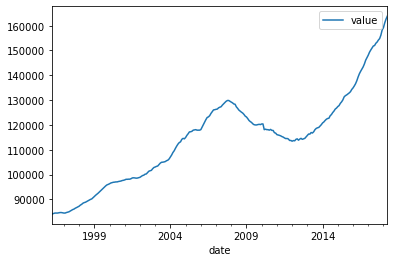

In [43]:
avg_prices = df.groupby('date').aggregate({'value':'median'})
avg_prices.plot();

In [44]:
df_merged_for_later_cv = df_merged_for_later.groupby('date').aggregate({'CV':'median'})
df_merged_for_later_cv

,CV
date,
1996-04-01,0.167782
1996-05-01,0.167782
1996-06-01,0.167782
1996-07-01,0.167782
1996-08-01,0.167782
...,...
2017-12-01,0.165783
2018-01-01,0.165783
2018-02-01,0.165783


In [45]:
all_df = df_cv.merge(df_merged_for_later_cv, left_index=True, right_index=True)
all_df.rename(columns={'value': 'texas_cv'}, inplace=True)

In [46]:
all_df.head()

,75002,75007,75023,75044,75052,75056,75068,75071,75074,75075,...,78681,78748,79109,79423,79424,79705,79707,79762,79912,CV
date,,,,,,,,,,,,,,,,,,,,,
1996-04-01,0.16743,0.189101,0.178363,0.184637,0.144309,0.170763,0.164294,0.158411,0.167933,0.191685,...,0.145447,0.170075,0.199167,0.203995,0.164215,0.215368,0.226812,0.234795,0.170412,0.167782
1996-05-01,0.16743,0.189101,0.178363,0.184637,0.144309,0.170763,0.164294,0.158411,0.167933,0.191685,...,0.145447,0.170075,0.199167,0.203995,0.164215,0.215368,0.226812,0.234795,0.170412,0.167782
1996-06-01,0.16743,0.189101,0.178363,0.184637,0.144309,0.170763,0.164294,0.158411,0.167933,0.191685,...,0.145447,0.170075,0.199167,0.203995,0.164215,0.215368,0.226812,0.234795,0.170412,0.167782
1996-07-01,0.16743,0.189101,0.178363,0.184637,0.144309,0.170763,0.164294,0.158411,0.167933,0.191685,...,0.145447,0.170075,0.199167,0.203995,0.164215,0.215368,0.226812,0.234795,0.170412,0.167782
1996-08-01,0.16743,0.189101,0.178363,0.184637,0.144309,0.170763,0.164294,0.158411,0.167933,0.191685,...,0.145447,0.170075,0.199167,0.203995,0.164215,0.215368,0.226812,0.234795,0.170412,0.167782


ROI zips v TX

Affordability zips vs TX

Map

In [47]:
df_merged_for_later['affordability'] = df_merged_for_later['value'] - df_merged_for_later['median_family_income']/.12
df_merged_for_later['affordability_score']  = normalize_data(df_merged_for_later['affordability'])
df_merged_for_later

,zipcode,city,state,county,ROI,std,mean,median,CV,value,year,population,median_family_income,latitude,longitude,affordability,affordability_score
date,,,,,,,,,,,,,,,,,
1996-04-01,75070,McKinney,TX,Collin,0.365295,33537.101427,219655.849057,205900.0,0.152680,235700.0,1996,104415.0,115530.0,33.172001,-96.695999,-7.270500e+05,0.515600
1996-04-01,77494,Katy,TX,Harris,0.567966,37730.794353,262110.566038,249700.0,0.143950,210400.0,1996,118291.0,148843.0,29.740999,-95.830002,-1.029958e+06,0.349509
1996-04-01,79936,El Paso,TX,El Paso,0.571798,18167.079218,101875.471698,112400.0,0.178326,77300.0,1996,111620.0,61016.0,31.777000,-106.296997,-4.311667e+05,0.677839
1996-04-01,77084,Houston,TX,Harris,0.729474,17242.109812,121185.283019,121400.0,0.142279,95000.0,1996,107673.0,70460.0,29.827000,-95.660004,-4.921667e+05,0.644391
1996-04-01,77449,Katy,TX,Harris,0.846960,18603.288493,126530.188679,124600.0,0.147026,95400.0,1996,128294.0,82716.0,29.837999,-95.734001,-5.939000e+05,0.588609
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-04-01,76941,Mertzon,TX,Irion,NaN,13734.029878,99318.367347,95600.0,0.138283,121600.0,2018,1455.0,64464.0,31.271999,-100.889000,-4.156000e+05,0.686374
2018-04-01,79313,Anton,TX,Hockley,NaN,5286.674724,54424.675325,53500.0,0.097137,63300.0,2018,1528.0,49250.0,33.805000,-102.162003,-3.471167e+05,0.723925
2018-04-01,79355,Plains,TX,Yoakum,NaN,12929.465872,78967.346939,77050.0,0.163732,93500.0,2018,1877.0,64563.0,33.181999,-102.876999,-4.445250e+05,0.670514


In [48]:
df_merged_for_later_5 = df_merged_for_later[df_merged_for_later['zipcode'].isin(zipcodes)]
df_merged_for_later_5

,zipcode,city,state,county,ROI,std,mean,median,CV,value,year,population,median_family_income,latitude,longitude,affordability,affordability_score
date,,,,,,,,,,,,,,,,,
1996-04-01,77449,Katy,TX,Harris,0.846960,18603.288493,126530.188679,124600.0,0.147026,95400.0,1996,128294.0,82716.0,29.837999,-95.734001,-593900.000000,0.588609
1996-04-01,78660,Pflugerville,TX,Travis,0.748020,24894.592870,168193.584906,165100.0,0.148012,138900.0,1996,91300.0,99733.0,30.440001,-97.595001,-692208.333333,0.534704
1996-04-01,77573,League City,TX,Galveston,0.848656,29647.359699,183261.509434,183500.0,0.161776,141400.0,1996,88131.0,121943.0,29.504000,-95.086998,-874791.666667,0.434590
1996-04-01,77584,Pearland,TX,Brazoria,0.851986,27064.756641,188628.301887,188400.0,0.143482,138500.0,1996,90372.0,126143.0,29.545000,-95.350998,-912691.666667,0.413809
1996-04-01,79912,El Paso,TX,El Paso,0.571429,26245.575483,154012.075472,171800.0,0.170412,119700.0,1996,78267.0,77146.0,31.849001,-106.533997,-523183.333333,0.627384
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-04-01,77377,Tomball,TX,Harris,0.643878,28541.747743,195482.641509,191800.0,0.146007,264500.0,2018,38469.0,102729.0,30.062000,-95.681999,-591575.000000,0.589883
2018-04-01,77571,La Porte,TX,Harris,1.040936,20507.800452,116197.358491,118400.0,0.176491,174500.0,2018,37427.0,85150.0,29.688000,-95.056999,-535083.333333,0.620859
2018-04-01,78108,Cibolo,TX,Guadalupe,0.706960,28284.399170,174170.566038,186100.0,0.162395,233000.0,2018,39999.0,107427.0,29.570000,-98.218002,-662225.000000,0.551145


In [49]:
df_tx_aff = df_merged_for_later.groupby('date').aggregate({'affordability_score':'median'})
df_tx_aff

,affordability_score
date,
1996-04-01,0.640439
1996-05-01,0.640439
1996-06-01,0.640393
1996-07-01,0.640366
1996-08-01,0.640384
...,...
2017-12-01,0.681476
2018-01-01,0.681629
2018-02-01,0.682077


In [50]:
df_aff = pd.DataFrame(df_merged_for_later_5[['zipcode','affordability_score']], index=df_merged_for_later_5.index)
df_aff.reset_index(inplace=True)

In [51]:
df_aff = df_aff.pivot('date', 'zipcode', 'affordability_score')
df_aff

zipcode,75002,75007,75023,75044,75052,75056,75068,75071,75074,75075,...,78665,78681,78748,79109,79423,79424,79705,79707,79762,79912
date,,,,,,,,,,,,,,,,,,,,,
1996-04-01,0.516249,0.545191,0.539621,0.620626,0.580128,0.496939,0.476491,0.465652,0.626018,0.553708,...,0.530144,0.460685,0.624231,0.592095,0.573818,0.511167,0.494188,0.407060,0.588248,0.627384
1996-05-01,0.515755,0.545191,0.539292,0.620626,0.580183,0.496390,0.476052,0.464610,0.625908,0.553489,...,0.529925,0.460631,0.623847,0.592040,0.573927,0.511277,0.494078,0.407005,0.588193,0.627384
1996-06-01,0.515371,0.545191,0.539018,0.620681,0.580238,0.495787,0.475668,0.463788,0.625853,0.553324,...,0.529815,0.460685,0.623354,0.592040,0.574092,0.511387,0.494023,0.406895,0.588193,0.627439
1996-07-01,0.515042,0.545191,0.538798,0.620681,0.580238,0.495239,0.475339,0.463185,0.625798,0.553215,...,0.529870,0.460960,0.622696,0.592040,0.574256,0.511496,0.493914,0.406840,0.588138,0.627494
1996-08-01,0.514823,0.545246,0.538634,0.620681,0.580347,0.494745,0.475065,0.462801,0.625798,0.553160,...,0.530034,0.461398,0.621819,0.592040,0.574421,0.511551,0.493859,0.406785,0.588083,0.627549
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-01,0.587914,0.618063,0.607009,0.681161,0.631396,0.565259,0.538944,0.530354,0.683920,0.633324,...,0.583989,0.526758,0.666562,0.632671,0.616148,0.560133,0.561741,0.481522,0.626137,0.663025
2018-01-01,0.588956,0.618227,0.608325,0.682257,0.631889,0.565808,0.539054,0.531122,0.685456,0.634531,...,0.583989,0.527361,0.667165,0.632780,0.616313,0.560078,0.562892,0.482618,0.626411,0.663080
2018-02-01,0.589669,0.619159,0.610080,0.683902,0.632712,0.566520,0.539548,0.532547,0.686443,0.636285,...,0.584318,0.528019,0.667823,0.633000,0.616313,0.559913,0.563934,0.484099,0.627233,0.663683


In [52]:
df_tx_aff = df_merged_for_later.groupby('date').aggregate({'affordability_score':'median'})
df_tx_aff

,affordability_score
date,
1996-04-01,0.640439
1996-05-01,0.640439
1996-06-01,0.640393
1996-07-01,0.640366
1996-08-01,0.640384
...,...
2017-12-01,0.681476
2018-01-01,0.681629
2018-02-01,0.682077


In [53]:
aff_df = df_aff.merge(df_tx_aff, left_index=True, right_index=True)
aff_df.rename(columns={'affordability_score': 'Texas'}, inplace=True)

In [54]:
aff_df = aff_df[['Texas', 75052, 75104, 76108, 77571, 79423]]
aff_df

,Texas,75052,75104,76108,77571,79423
date,,,,,,
1996-04-01,0.640439,0.580128,0.588248,0.593269,0.572058,0.573818
1996-05-01,0.640439,0.580183,0.588357,0.593215,0.572113,0.573927
1996-06-01,0.640393,0.580238,0.588467,0.593160,0.572223,0.574092
1996-07-01,0.640366,0.580238,0.588631,0.593160,0.572278,0.574256
1996-08-01,0.640384,0.580347,0.588741,0.593160,0.572333,0.574421
...,...,...,...,...,...,...
2017-12-01,0.681476,0.631396,0.635458,0.635326,0.618556,0.616148
2018-01-01,0.681629,0.631889,0.636884,0.636313,0.619379,0.616313
2018-02-01,0.682077,0.632712,0.638035,0.637300,0.620091,0.616313


In [55]:
df_merged_for_later_5.head()

,zipcode,city,state,county,ROI,std,mean,median,CV,value,year,population,median_family_income,latitude,longitude,affordability,affordability_score
date,,,,,,,,,,,,,,,,,
1996-04-01,77449,Katy,TX,Harris,0.846960,18603.288493,126530.188679,124600.0,0.147026,95400.0,1996,128294.0,82716.0,29.837999,-95.734001,-593900.000000,0.588609
1996-04-01,78660,Pflugerville,TX,Travis,0.748020,24894.592870,168193.584906,165100.0,0.148012,138900.0,1996,91300.0,99733.0,30.440001,-97.595001,-692208.333333,0.534704
1996-04-01,77573,League City,TX,Galveston,0.848656,29647.359699,183261.509434,183500.0,0.161776,141400.0,1996,88131.0,121943.0,29.504000,-95.086998,-874791.666667,0.434590
1996-04-01,77584,Pearland,TX,Brazoria,0.851986,27064.756641,188628.301887,188400.0,0.143482,138500.0,1996,90372.0,126143.0,29.545000,-95.350998,-912691.666667,0.413809
1996-04-01,79912,El Paso,TX,El Paso,0.571429,26245.575483,154012.075472,171800.0,0.170412,119700.0,1996,78267.0,77146.0,31.849001,-106.533997,-523183.333333,0.627384


In [56]:
df_tx_roi = df_merged_for_later.groupby('date').aggregate({'ROI':'mean'})
df_tx_roi

,ROI
date,
1996-04-01,0.940549
1996-05-01,0.940549
1996-06-01,0.940549
1996-07-01,0.940549
1996-08-01,0.940549
...,...
2017-12-01,0.940549
2018-01-01,0.940549
2018-02-01,0.940549


In [57]:
df_roi = pd.DataFrame(df_merged_for_later_5[['zipcode','ROI']], index=df_merged_for_later_5.index)
df_roi.reset_index(inplace=True)

In [58]:
df_roi = df_roi.pivot('date', 'zipcode', 'ROI')
df_roi

zipcode,75002,75007,75023,75044,75052,75056,75068,75071,75074,75075,...,78665,78681,78748,79109,79423,79424,79705,79707,79762,79912
date,,,,,,,,,,,,,,,,,,,,,
1996-04-01,0.877749,1.086139,0.915984,1.192079,0.99504,0.900412,0.814969,0.685423,0.926471,1.021108,...,0.617299,0.730994,0.413534,0.921951,1.082037,0.793722,0.987786,0.982216,0.923264,0.571429
1996-05-01,0.877749,1.086139,0.915984,1.192079,0.99504,0.900412,0.814969,0.685423,0.926471,1.021108,...,0.617299,0.730994,0.413534,0.921951,1.082037,0.793722,0.987786,0.982216,0.923264,0.571429
1996-06-01,0.877749,1.086139,0.915984,1.192079,0.99504,0.900412,0.814969,0.685423,0.926471,1.021108,...,0.617299,0.730994,0.413534,0.921951,1.082037,0.793722,0.987786,0.982216,0.923264,0.571429
1996-07-01,0.877749,1.086139,0.915984,1.192079,0.99504,0.900412,0.814969,0.685423,0.926471,1.021108,...,0.617299,0.730994,0.413534,0.921951,1.082037,0.793722,0.987786,0.982216,0.923264,0.571429
1996-08-01,0.877749,1.086139,0.915984,1.192079,0.99504,0.900412,0.814969,0.685423,0.926471,1.021108,...,0.617299,0.730994,0.413534,0.921951,1.082037,0.793722,0.987786,0.982216,0.923264,0.571429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-01,0.877749,1.086139,0.915984,1.192079,0.99504,0.900412,0.814969,0.685423,0.926471,1.021108,...,0.617299,0.730994,0.413534,0.921951,1.082037,0.793722,0.987786,0.982216,0.923264,0.571429
2018-01-01,0.877749,1.086139,0.915984,1.192079,0.99504,0.900412,0.814969,0.685423,0.926471,1.021108,...,0.617299,0.730994,0.413534,0.921951,1.082037,0.793722,0.987786,0.982216,0.923264,0.571429
2018-02-01,0.877749,1.086139,0.915984,1.192079,0.99504,0.900412,0.814969,0.685423,0.926471,1.021108,...,0.617299,0.730994,0.413534,0.921951,1.082037,0.793722,0.987786,0.982216,0.923264,0.571429


In [59]:
df_roi = df_roi.merge(df_tx_roi, left_index=True, right_index=True)
df_roi.rename(columns={'ROI': 'Average ROI'}, inplace=True)

In [60]:
df_roi = df_roi[[75052, 75104, 76108, 77571, 79423]]
df_roi

,75052,75104,76108,77571,79423
date,,,,,
1996-04-01,0.99504,0.954222,1.01348,1.040936,1.082037
1996-05-01,0.99504,0.954222,1.01348,1.040936,1.082037
1996-06-01,0.99504,0.954222,1.01348,1.040936,1.082037
1996-07-01,0.99504,0.954222,1.01348,1.040936,1.082037
1996-08-01,0.99504,0.954222,1.01348,1.040936,1.082037
...,...,...,...,...,...
2017-12-01,0.99504,0.954222,1.01348,1.040936,1.082037
2018-01-01,0.99504,0.954222,1.01348,1.040936,1.082037
2018-02-01,0.99504,0.954222,1.01348,1.040936,1.082037


In [61]:
df_merged['ROI'].mean()

0.9405485939508469

In [62]:
df_merged_for_later.head()

,zipcode,city,state,county,ROI,std,mean,median,CV,value,year,population,median_family_income,latitude,longitude,affordability,affordability_score
date,,,,,,,,,,,,,,,,,
1996-04-01,75070,McKinney,TX,Collin,0.365295,33537.101427,219655.849057,205900.0,0.152680,235700.0,1996,104415.0,115530.0,33.172001,-96.695999,-7.270500e+05,0.515600
1996-04-01,77494,Katy,TX,Harris,0.567966,37730.794353,262110.566038,249700.0,0.143950,210400.0,1996,118291.0,148843.0,29.740999,-95.830002,-1.029958e+06,0.349509
1996-04-01,79936,El Paso,TX,El Paso,0.571798,18167.079218,101875.471698,112400.0,0.178326,77300.0,1996,111620.0,61016.0,31.777000,-106.296997,-4.311667e+05,0.677839
1996-04-01,77084,Houston,TX,Harris,0.729474,17242.109812,121185.283019,121400.0,0.142279,95000.0,1996,107673.0,70460.0,29.827000,-95.660004,-4.921667e+05,0.644391
1996-04-01,77449,Katy,TX,Harris,0.846960,18603.288493,126530.188679,124600.0,0.147026,95400.0,1996,128294.0,82716.0,29.837999,-95.734001,-5.939000e+05,0.588609


In [63]:
df_merged_for_later

,zipcode,city,state,county,ROI,std,mean,median,CV,value,year,population,median_family_income,latitude,longitude,affordability,affordability_score
date,,,,,,,,,,,,,,,,,
1996-04-01,75070,McKinney,TX,Collin,0.365295,33537.101427,219655.849057,205900.0,0.152680,235700.0,1996,104415.0,115530.0,33.172001,-96.695999,-7.270500e+05,0.515600
1996-04-01,77494,Katy,TX,Harris,0.567966,37730.794353,262110.566038,249700.0,0.143950,210400.0,1996,118291.0,148843.0,29.740999,-95.830002,-1.029958e+06,0.349509
1996-04-01,79936,El Paso,TX,El Paso,0.571798,18167.079218,101875.471698,112400.0,0.178326,77300.0,1996,111620.0,61016.0,31.777000,-106.296997,-4.311667e+05,0.677839
1996-04-01,77084,Houston,TX,Harris,0.729474,17242.109812,121185.283019,121400.0,0.142279,95000.0,1996,107673.0,70460.0,29.827000,-95.660004,-4.921667e+05,0.644391
1996-04-01,77449,Katy,TX,Harris,0.846960,18603.288493,126530.188679,124600.0,0.147026,95400.0,1996,128294.0,82716.0,29.837999,-95.734001,-5.939000e+05,0.588609
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-04-01,76941,Mertzon,TX,Irion,NaN,13734.029878,99318.367347,95600.0,0.138283,121600.0,2018,1455.0,64464.0,31.271999,-100.889000,-4.156000e+05,0.686374
2018-04-01,79313,Anton,TX,Hockley,NaN,5286.674724,54424.675325,53500.0,0.097137,63300.0,2018,1528.0,49250.0,33.805000,-102.162003,-3.471167e+05,0.723925
2018-04-01,79355,Plains,TX,Yoakum,NaN,12929.465872,78967.346939,77050.0,0.163732,93500.0,2018,1877.0,64563.0,33.181999,-102.876999,-4.445250e+05,0.670514


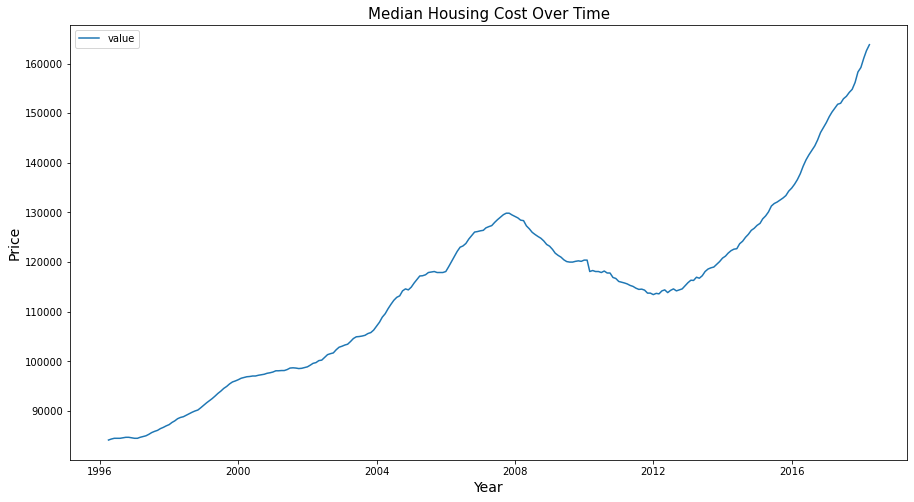

In [64]:
fig, ax = plt.subplots()
ax.set_title('Median Housing Cost Over Time', fontsize=15)
ax.set_xlabel('Year', fontsize=14)
ax.set_ylabel('Price', fontsize=14)
sns.lineplot(data=df_merged_for_later.groupby('date').aggregate({'value':'median'}))
fig.set_size_inches(15,8);

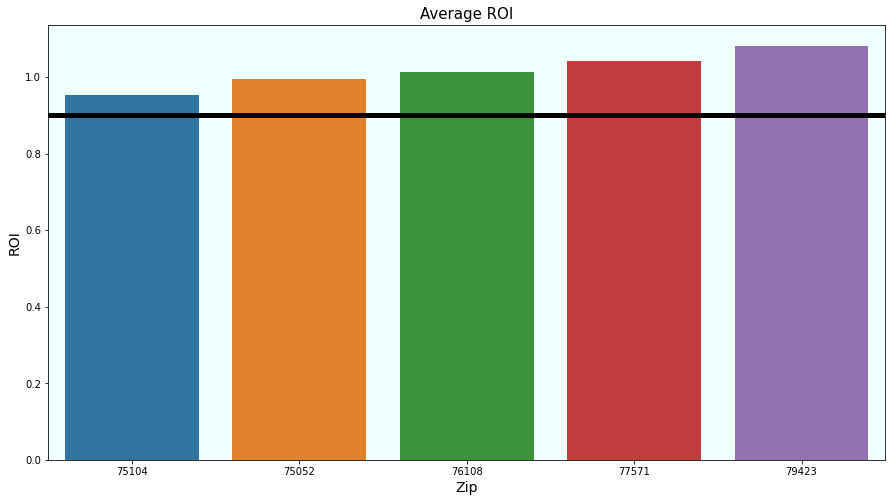

In [65]:
fig, ax = plt.subplots()
ax.set_title('Average ROI', fontsize=15)
ax.set_xlabel('Zip', fontsize=14)
ax.set_ylabel('ROI', fontsize=14)
sns.barplot(data=df_roi, linewidth=4,order=[75104, 75052,76108,77571,79423]).axhline(df_filtered['ROI'].mean(),linewidth=5,color='black')
fig.set_size_inches(15, 8)
ax.set_facecolor('azure');
plt.savefig('images/average_roi')

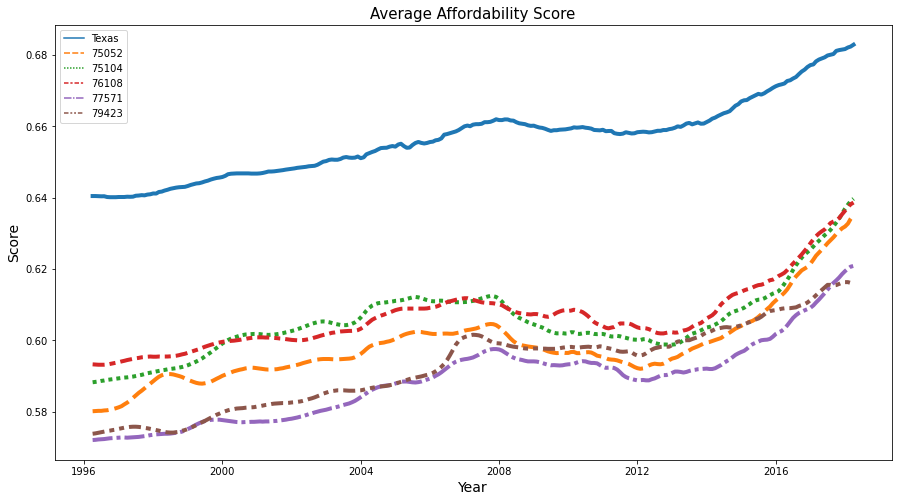

In [66]:
fig, ax = plt.subplots()
ax.set_title('Average Affordability Score', fontsize=15)
ax.set_xlabel('Year', fontsize=14)
ax.set_ylabel('Score', fontsize=14)
sns.lineplot(data=aff_df, linewidth=4)
fig.set_size_inches(15, 8);
plt.savefig('images/avg_aff_score')

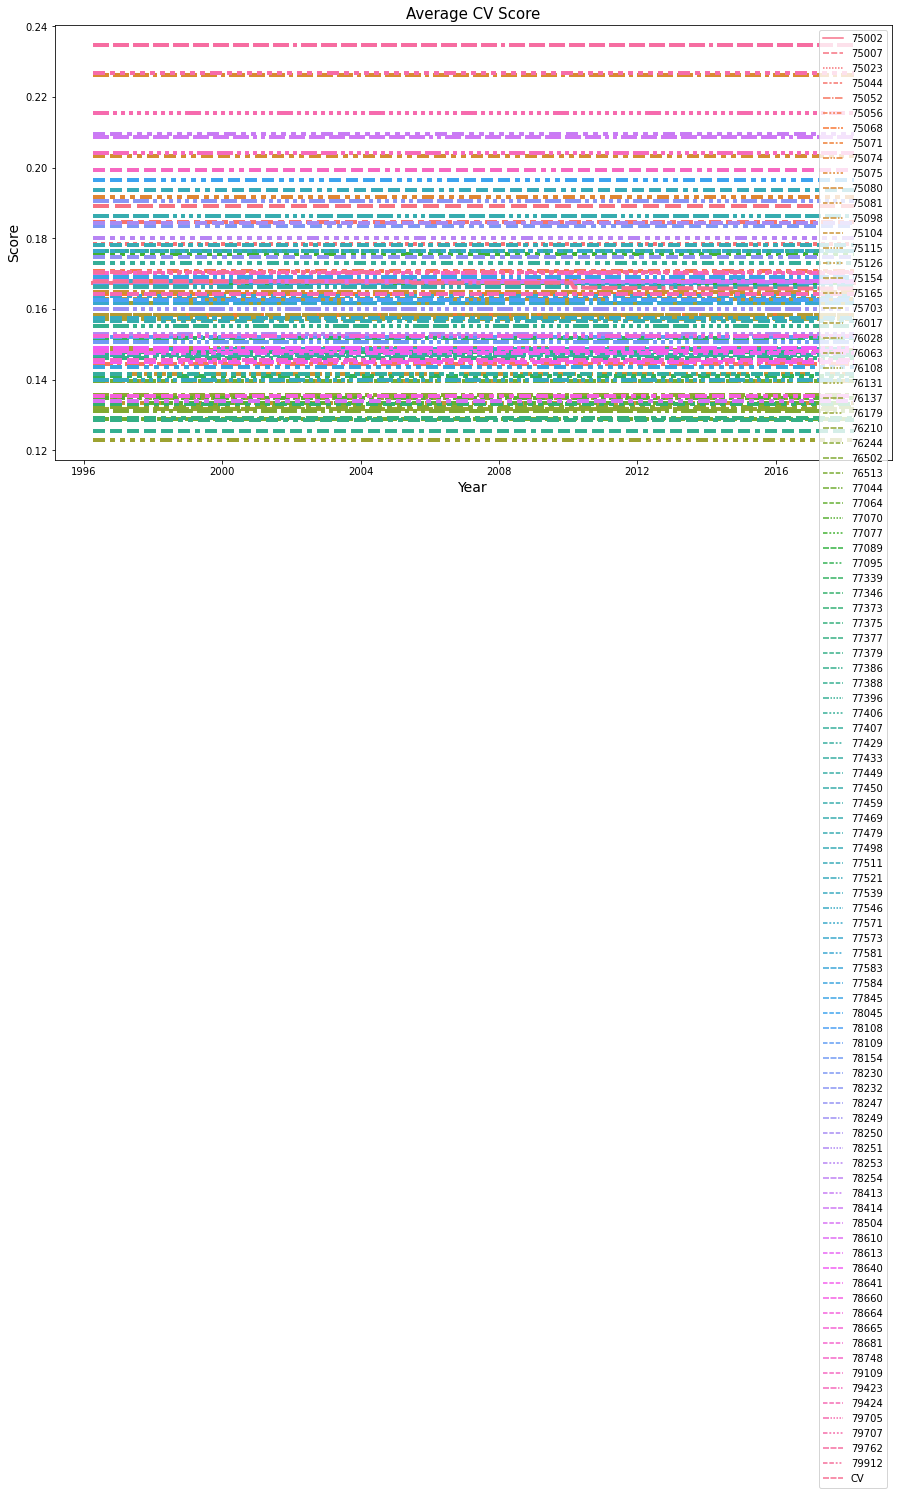

In [67]:
fig, ax = plt.subplots()
ax.set_title('Average CV Score', fontsize=15)
ax.set_xlabel('Year', fontsize=14)
ax.set_ylabel('Score', fontsize=14)
sns.lineplot(data=all_df, linewidth=4)
fig.set_size_inches(15, 8);

Zipcodes are close in proximity
Sense of stability

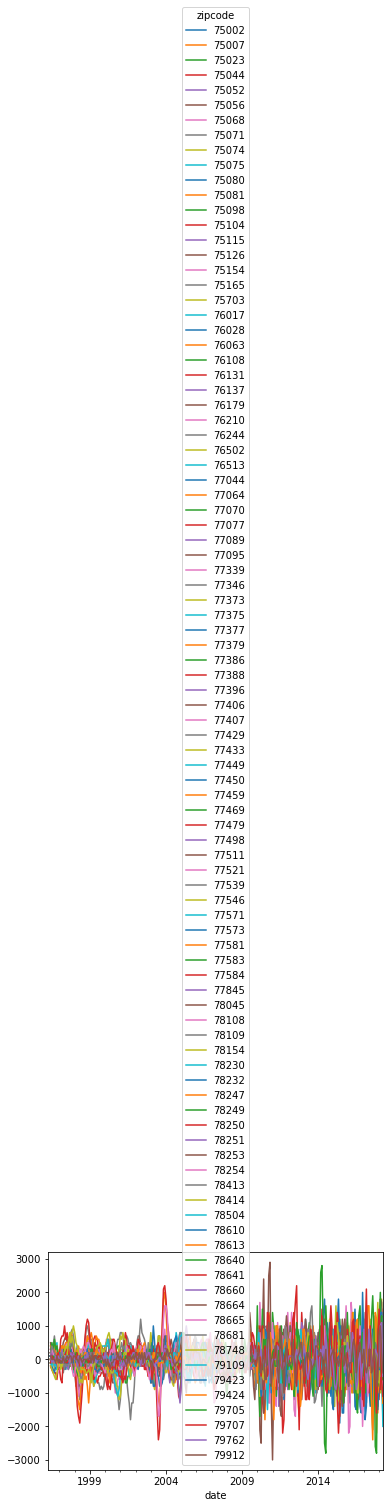

In [68]:
df_diff = df_prices.diff().diff()
df_diff.plot();

### Create a DF for each zip

In [69]:
df_76108 = pd.DataFrame(df_prices[76108][df_prices[76108].notnull()]).astype(int).reset_index()
df_76108['value'] = df_76108[76108]
df_76108.drop(df_76108.columns[np.r_[1]], axis=1, inplace=True)

In [70]:
df_76108.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 265 entries, 0 to 264
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    265 non-null    datetime64[ns]
 1   value   265 non-null    int32         
dtypes: datetime64[ns](1), int32(1)
memory usage: 3.2 KB


### Inspect zip df

In [71]:
df_76108.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 265 entries, 0 to 264
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    265 non-null    datetime64[ns]
 1   value   265 non-null    int32         
dtypes: datetime64[ns](1), int32(1)
memory usage: 3.2 KB


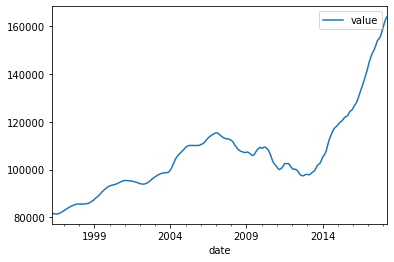

In [72]:
median_76108 = df_76108.groupby('date').aggregate({'value': 'median'})
median_76108.plot();

### Stationarity Check

In [73]:
def stationarity_check(df):
    roll_mean = df.rolling(window=12, center=False).mean()
    roll_std = df.rolling(window=12, center=False).std()
    
    df_test = adfuller(df)
    print('Results of Dickey-Fuller Test: \n')

    dfoutput = pd.Series(df_test[0:4], index=['Test Statistic', 'p-value', 
                                             '#Lags Used', 'Number of Observations Used'])
    for key,value in df_test[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    roll_mean.plot()
    roll_std.plot()
    return None

In [74]:
df_76108.set_index(['date'], inplace=True)
df_76108.head()

,value
date,
1996-04-01,81600
1996-05-01,81500
1996-06-01,81400
1996-07-01,81400
1996-08-01,81400


In [75]:
df_76108

,value
date,
1996-04-01,81600
1996-05-01,81500
1996-06-01,81400
1996-07-01,81400
1996-08-01,81400
...,...
2017-12-01,158300
2018-01-01,160100
2018-02-01,161900


Results of Dickey-Fuller Test: 

Test Statistic                   0.316514
p-value                          0.978090
#Lags Used                      15.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


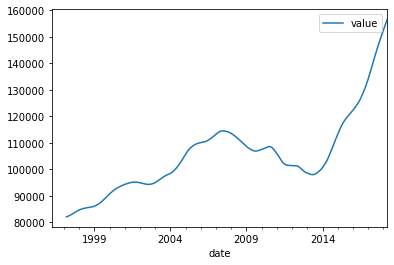

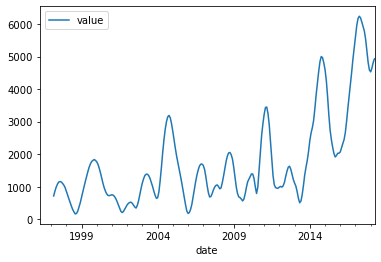

In [76]:
stationarity_check(df_76108)

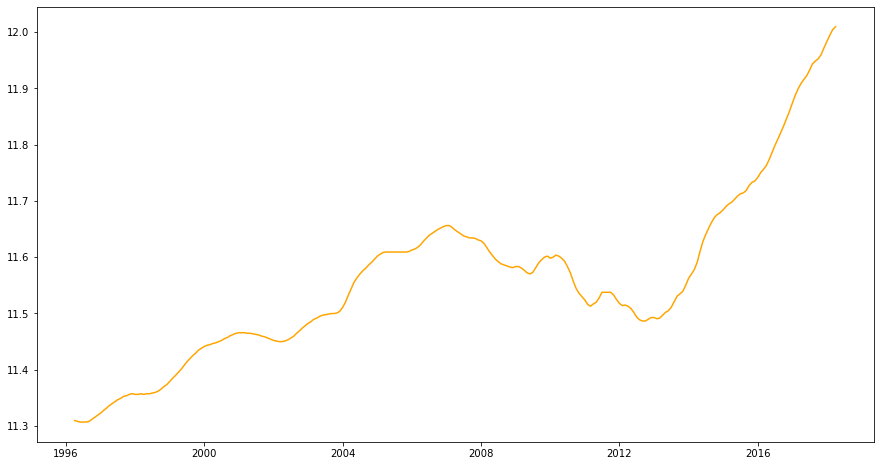

In [77]:
df_76108_log = np.log(df_76108)
fig = plt.figure(figsize=(15,8))
plt.plot(df_76108_log, color = 'orange');

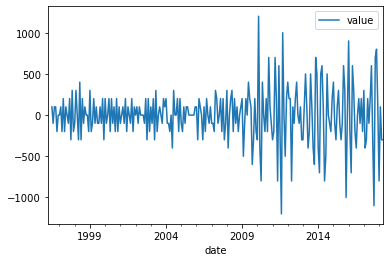

In [78]:
df_76108_diff = df_76108.diff().diff().diff()
df_76108_diff.plot();

In [79]:
df_76_log_diff = df_76108_log.diff().diff().diff()

## Train-Test-Split & ARIMA

In [80]:
X = df_76108.index
y = df_76108['value']

In [81]:
train = df_76108[:-24]
test = df_76108[-241:]

<AxesSubplot:xlabel='date'>

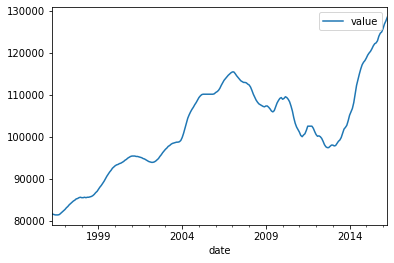

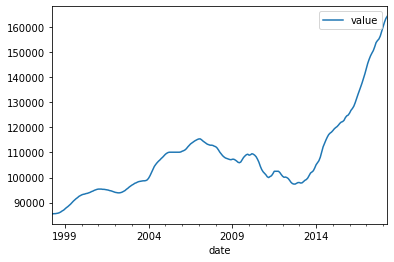

In [82]:
train.plot()
test.plot()

In [83]:
tscv = TimeSeriesSplit(n_splits=3)
for train_index, test_index in tscv.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66] TEST: [ 67  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82  83  84
  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102
 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120
 121 122 123 124 125 126 127 128 129 130 131 132]
TRAIN: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124

In [84]:
print(f"""Min Lat: {df_income['latitude'].min()}\nMax Lat: {df_income['latitude'].max()},
Min Long: {df_income['longitude'].min()},\nMax Long: {df_income['longitude'].max()}""")

Min Lat: 25.944000000000003
Max Lat: 36.380001,
Min Long: -106.608002,
Max Long: -93.615997


In [85]:
# import folium
import folium

# this is about the center of Texas per google search
lat = 31.5
long = -99.9

# create base texas map
tx_map = folium.Map(location=[lat, long],min_lat=df_income['latitude'].min(),max_lat=df_income['latitude'].max(),
                      min_lon=df_income['longitude'].min(),max_lon=df_income['longitude'].max(),
                      max_bounds=True,zoom_start=6)

In [86]:
# plotting our points
x = df_income['latitude']
y = df_income['longitude']
points = list(zip(x, y))
for p in points:
    lat = p[0]
    long = p[1]
    marker = folium.Circle(radius=5,location=[lat, long],color='green')
    marker.add_to(tx_map)

In [87]:
# plotting our main zips
x5 = df_filtered_top_roi['latitude']
y5 = df_filtered_top_roi['longitude']
c5 = df_filtered_top_roi['city']
z5 = df_filtered_top_roi['zipcode']
main_points = list(zip(x5,y5,c5,z5))
for p in main_points:
    lat = p[0]
    long = p[1]
    city = p[2]
    zips = p[3]
    popup_text = "Zip: {} \n\n City: {}".format(zips, city)
    popup = folium.Popup(popup_text,parse_html=True)
    marker = folium.Marker(location=[lat,long], popup=popup)
    marker.add_to(tx_map)

In [88]:
tx_map

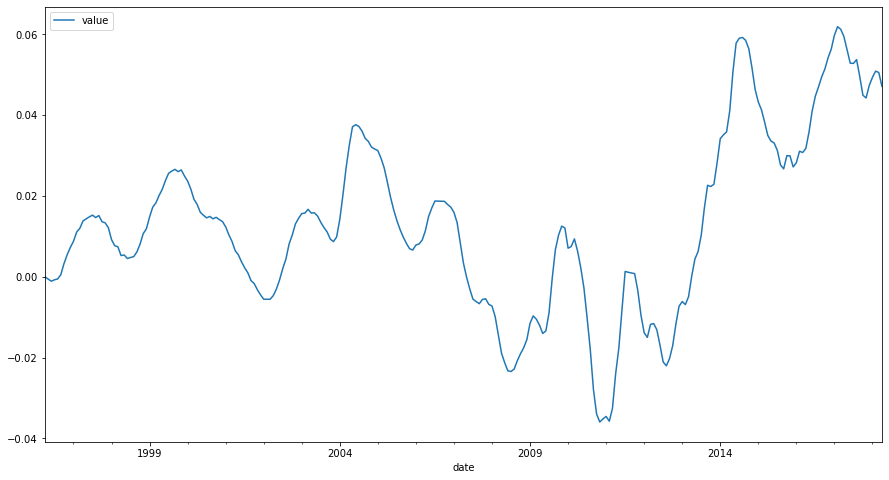

In [89]:
weight_roll_mean = df_76108_log.ewm(halflife=4).mean()
df_log_wrm = df_76108_log - weight_roll_mean
df_log_wrm.plot(figsize=(15,8));